In [25]:
# Core libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn model, metrics, preprocessing, and pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# TensorFlow and Keras for neural networks
import tensorflow as tf
from tensorflow.keras import Sequential, layers,optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import F1Score

# Stats and other utilities
from scipy.stats import linregress
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Loading MOH Lung Cancer Survey Dataset

In [20]:
# Load the lung cancer dataset and set tagret/feature variables
MOH_data = pd.read_csv('lung cancer survey.csv')
MOH_data = MOH_data.dropna() #removing rows with missing values
MOH_data.columns = MOH_data.columns.str.replace('_', ' ') #removed underscores from column names to standardised 

#We idenrtifed our target and predictors 
X = MOH_data.drop(['LUNG CANCER','ALLERGY ','ANXIETY','PEER PRESSURE'],axis =1) #remove columns that we deemed irrevlant as predictora
y = MOH_data['LUNG CANCER'] #target variable

# Split the data into training and validation sets (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=888)

# Multiple Logistic Regression

In [21]:
# Initialize and fit the logistic regression model with training data
logistic_model = LogisticRegression(penalty=None, random_state=888) 
logistic_model.fit(X_train, y_train)

# Predicted y values on validation set
y_pred_logistic = logistic_model.predict(X_val)

# Evaluate the model on the validation set based on F1-Score
print(f"Multiple Logistic Regression F1 Score on Validation Set: {f1_score(y_val, y_pred_logistic)}")

Multiple Logistic Regression F1 Score on Validation Set: 0.9160599571734475


# Logistic Regression Assumption

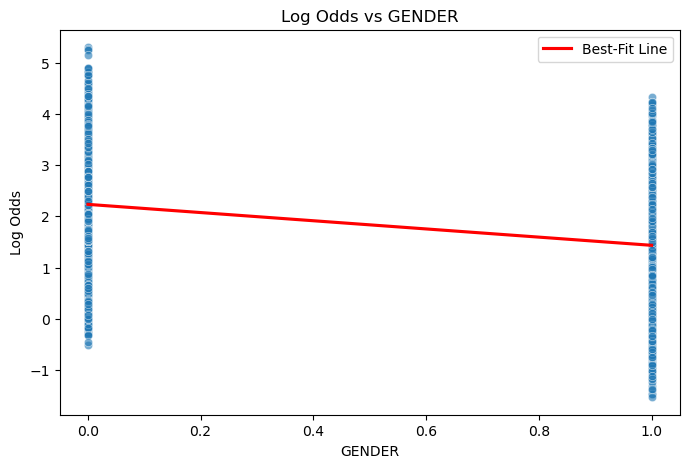

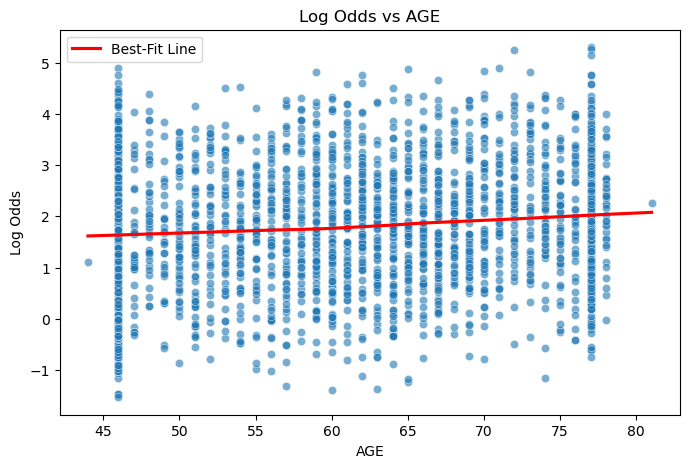

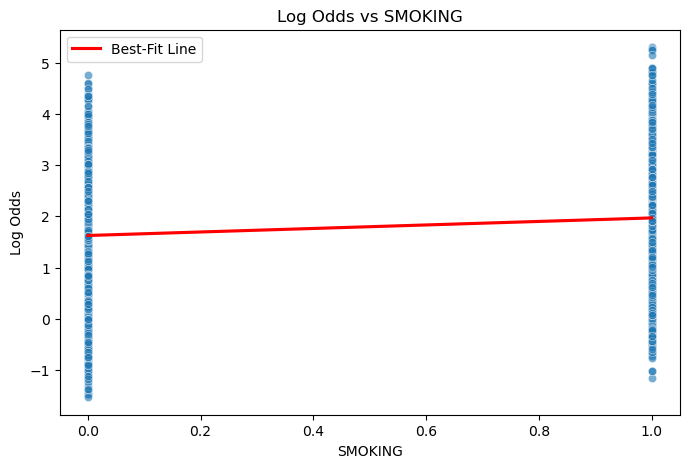

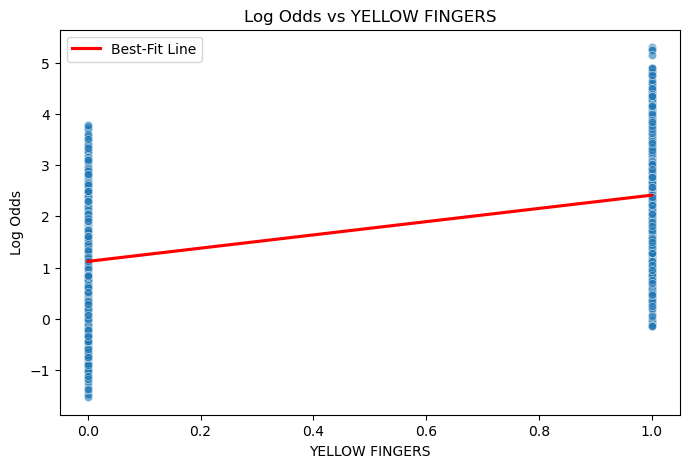

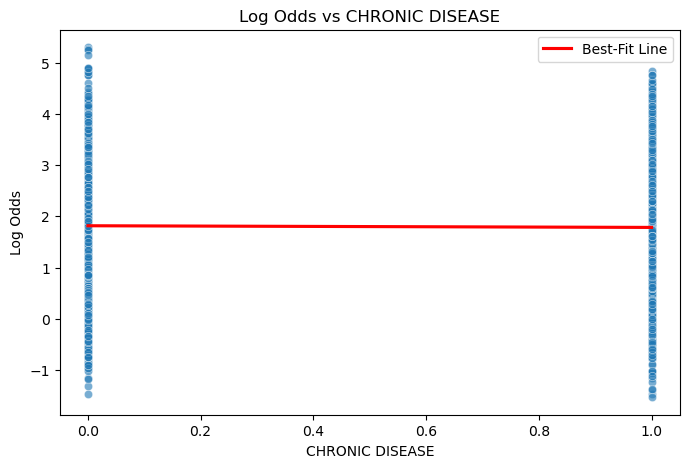

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


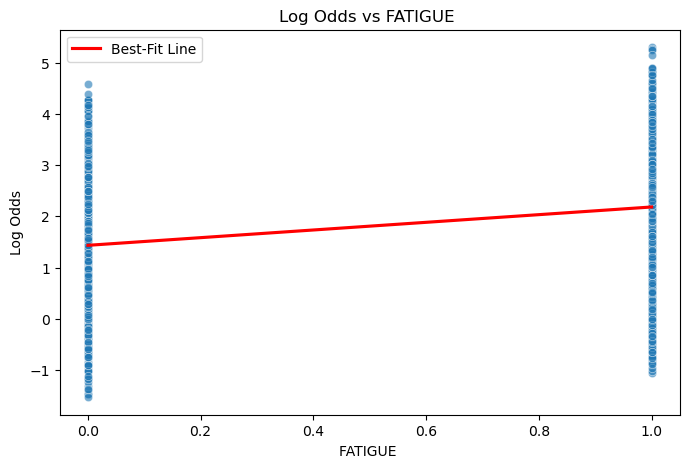

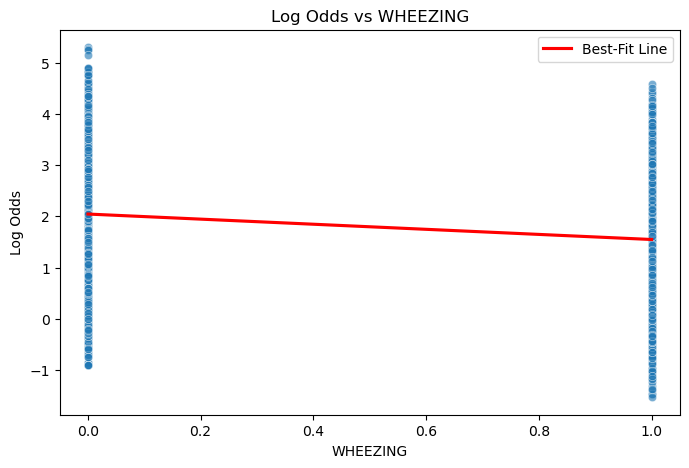

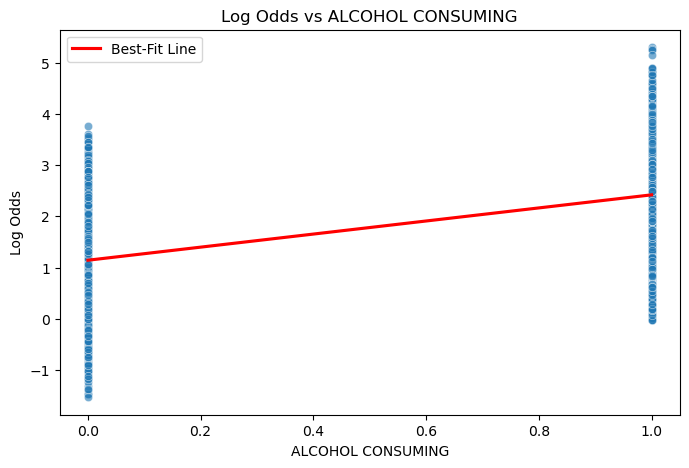

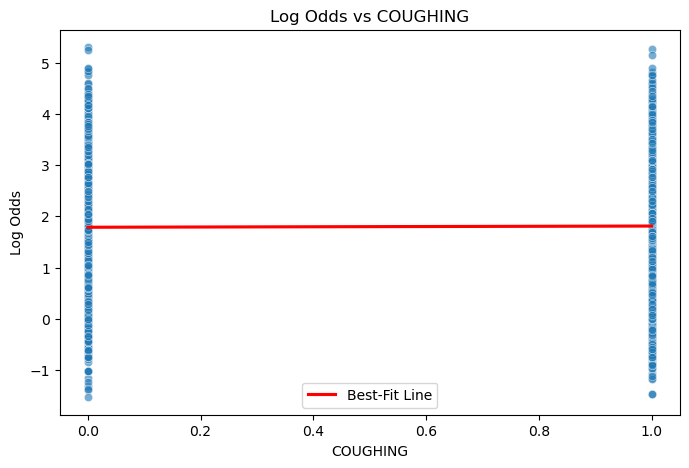

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


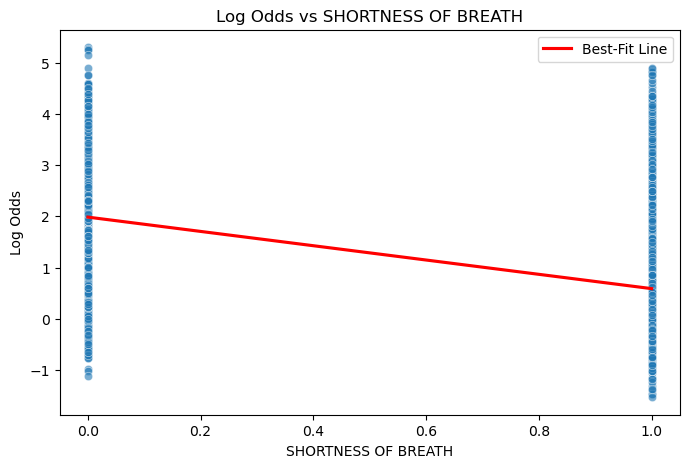

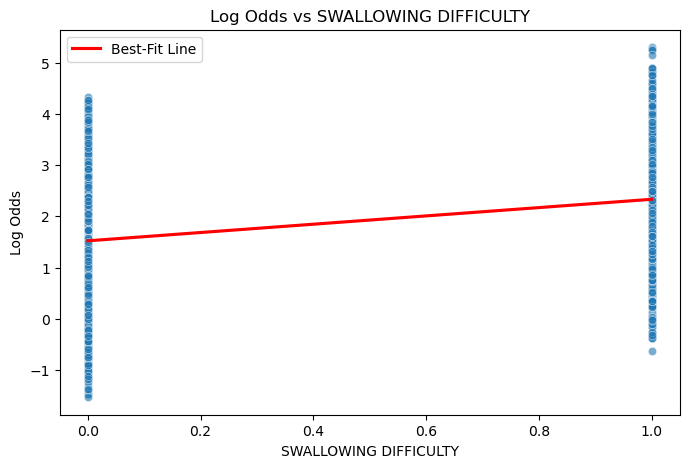

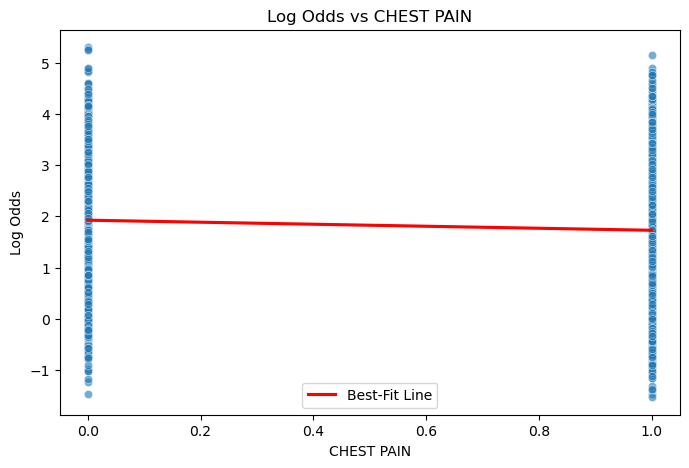

,Feature,VIF
0,GENDER,1.009100
1,AGE,1.002839
2,SMOKING,1.002935
3,YELLOW FINGERS,1.013424
4,CHRONIC DISEASE,1.011064
5,FATIGUE,1.009239
6,WHEEZING,1.025302
7,ALCOHOL CONSUMING,1.031298
8,COUGHING,1.024099
9,SHORTNESS OF BREATH,1.004253


In [22]:
##Assumption of Linearity

#Obtain the log-odds values for the linearity assumption plot
X_val_with_const = X_val.copy()    #copied training data
X_val_with_const['Intercept'] = 1  # Add an intercept term for calculating the log odds
log_odds = X_val_with_const.dot(np.append(logistic_model.coef_.flatten(), logistic_model.intercept_)) #flattening of coefficients

# Plot the log odds against each independent variable with a LOWESS smoother in case of non-linear relationships
for feature in X.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=X_val[feature], y=log_odds, alpha=0.6)
    sns.regplot(x=X_val[feature], y=log_odds, lowess=True, scatter=False, color="red", label="Best-Fit Line")
    
    #adding plot items such axis and legends for each feature
    plt.xlabel(feature)
    plt.ylabel('Log Odds')
    plt.title(f'Log Odds vs {feature}')
    plt.legend()
    plt.show()
    
##Assumption of Multicolinearity

# Calculate VIF for each independent variable
X_with_const = X_train.copy()  #copied training data
X_with_const['Intercept'] = 1  # Adding an intercept for VIF calculation
vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Display VIF values for each feature
display(vif_data[vif_data['Feature'] != 'Intercept'])  # Exclude intercept from the display

# Regularisation Techniques

In [23]:
# Define cross-validation strategy and Generate a large grid for C values
kf = KFold(n_splits=5, shuffle=True, random_state=888)
C_grid = np.logspace(-5, 3, num=10)  # From 10^-5 to 10^3 with 10 points

# Define parameter grids
param_grids = {
    'Lasso': {'C': C_grid},
    'Ridge': {'C': C_grid},
    'ElasticNet': {'C': C_grid, 'l1_ratio': np.linspace(0.01, 1, num=5)}
}

# Initialise each regularisation model
regression_models = {
    'Lasso': LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000, random_state=888),
    'Ridge': LogisticRegression(penalty='l2', solver='liblinear', max_iter=10000, random_state=888),
    'ElasticNet': LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, random_state=888)
}

# Perform Grid Search with CV on the training set to retrieve best model, predict on the validation set, Calculate F1-score
for name, model in regression_models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=kf, scoring='f1').fit(X_train, y_train)
    y_pred = grid_search.best_estimator_.predict(X_val)
    print(f"Best parameters for {name} Logistic Regression: {grid_search.best_params_}\n"
          f"Best cross-validated f1-score for {name} Logistic Regression: {grid_search.best_score_}\n"
          f"{name} Logistic Regression F1 Score on Validation Set: {f1_score(y_val, y_pred)}\n")

Best parameters for Lasso Logistic Regression: {'C': 16.681005372000556}
Best cross-validated f1-score for Lasso Logistic Regression: 0.9227405315301297
Lasso Logistic Regression F1 Score on Validation Set: 0.9160599571734475

Best parameters for Ridge Logistic Regression: {'C': 2.154434690031882}
Best cross-validated f1-score for Ridge Logistic Regression: 0.9226827159725053
Ridge Logistic Regression F1 Score on Validation Set: 0.9163278407875026

Best parameters for ElasticNet Logistic Regression: {'C': 16.681005372000556, 'l1_ratio': 0.01}
Best cross-validated f1-score for ElasticNet Logistic Regression: 0.9227098108534711
ElasticNet Logistic Regression F1 Score on Validation Set: 0.9163636363636364



# Decision Tree

Decision Tree F1 Score on Validation Set: 0.8882486108252726


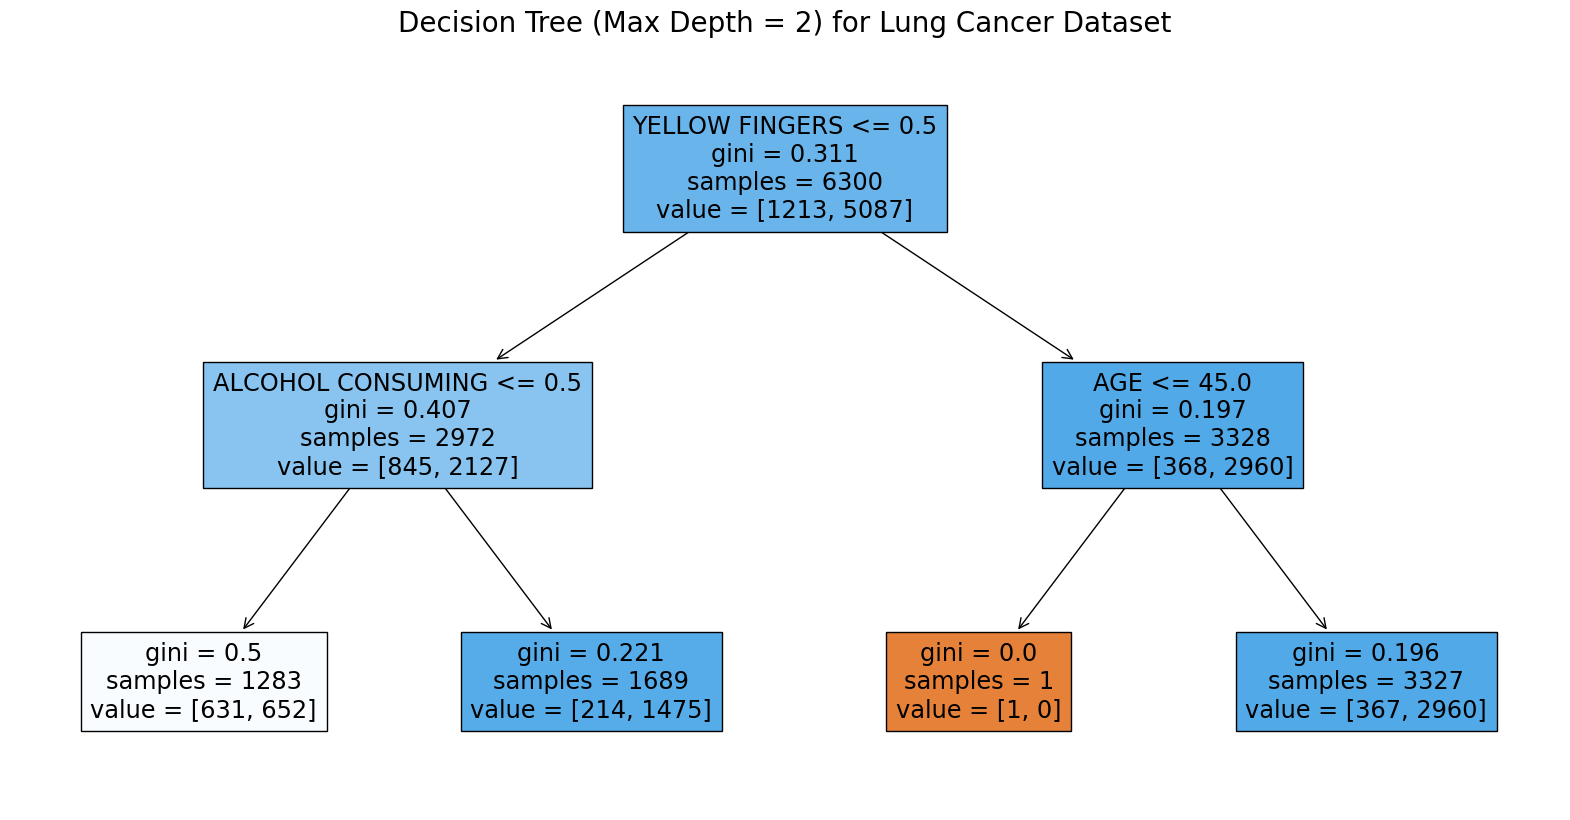

In [6]:
# Initialize and fit the Decision Tree with classifier on the training data
tree_model = DecisionTreeClassifier(criterion='gini',max_depth = 2, random_state=888) #max-depth = 2 for easier reading
tree_model.fit(X_train, y_train)

# Evaluate the model's performance on the validation data
y_pred_val_tree = tree_model.predict(X_val)
print(f"Decision Tree F1 Score on Validation Set: {f1_score(y_val, y_pred_val_tree)}")

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, filled=True)
plt.title("Decision Tree (Max Depth = 2) for Lung Cancer Dataset", fontsize = 20)
plt.show()

# Pruned Decision Tree

Optimal alpha: 0.0007024161024161029
Pruned Decision Tree F1 Score on Validation Set: 0.9104671280276817


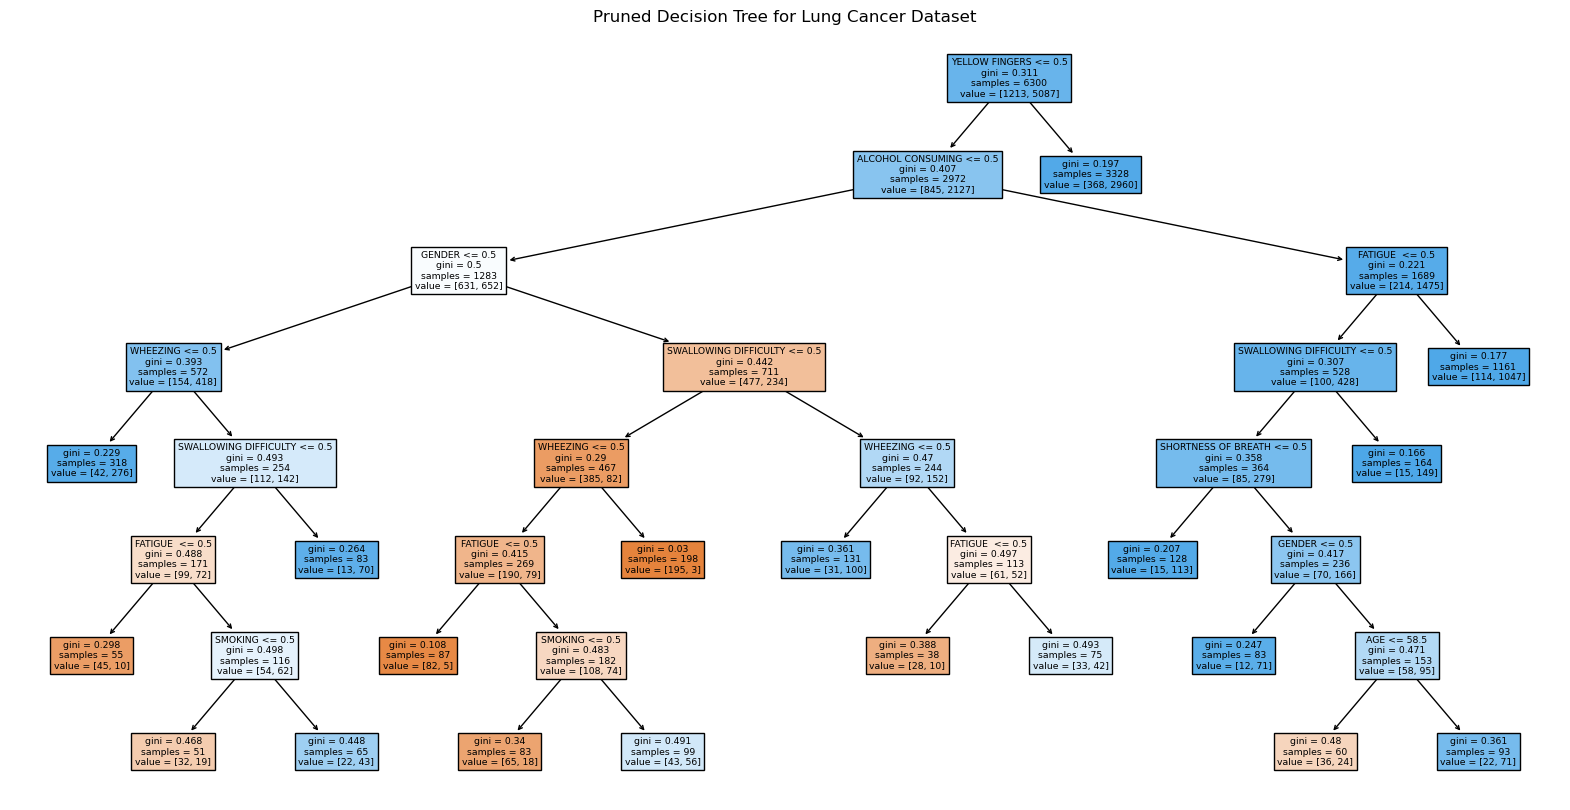

In [7]:
# Initialise Decision Tree with Maximum Depth
tree_model_max_depth = DecisionTreeClassifier(criterion='gini', random_state=888)

# Use cost complexity pruning to get a sequence of alphas
path = tree_model_max_depth.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas  # effective alphas of each subtree

# Define the Decision Tree for each alpha
trees = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini', random_state=888, ccp_alpha=ccp_alpha)
    trees.append(clf)

#Define average cross validation errors from hyperparameter tuning
mean_cv_errors = []

for clf in trees:
    # Perform cross-validation and get the average error for each alpha
    cv_scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='f1') #re-use kf from previous code
    mean_cv_errors.append(np.mean(cv_scores))  # Get average f1 score for each alpha

#Find the optimal alpha (the one that maximizes the cross-validated F1-Score)
optimal_alpha_index = np.argmax(mean_cv_errors)
optimal_alpha = ccp_alphas[optimal_alpha_index]
print(f"Optimal alpha: {optimal_alpha}")

#Prune the tree using the optimal alpha on the training set
pruned_tree = DecisionTreeClassifier(criterion='gini', random_state=888, ccp_alpha=optimal_alpha)
pruned_tree.fit(X_train, y_train)

#Make predictions on the validation data
y_pred_pruned = pruned_tree.predict(X_val) 

# Evaluate the pruned tree on the validation set
print(f"Pruned Decision Tree F1 Score on Validation Set: {f1_score(y_val, y_pred_pruned)}")

# Visualize the pruned decision tree
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, feature_names=X.columns, filled=True)
plt.title("Pruned Decision Tree for Lung Cancer Dataset")
plt.show()

# Bagging and Random Forest

Bagging F1 Score on Validation Set: 0.900972590627763


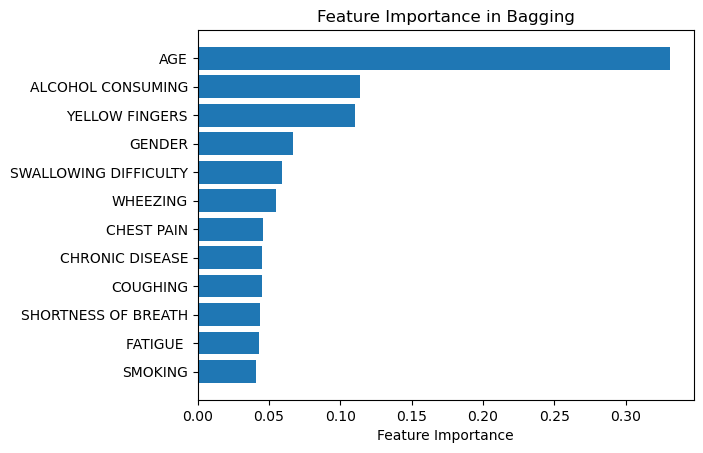

Random Forest F1 Score on Validation Set: 0.900972590627763


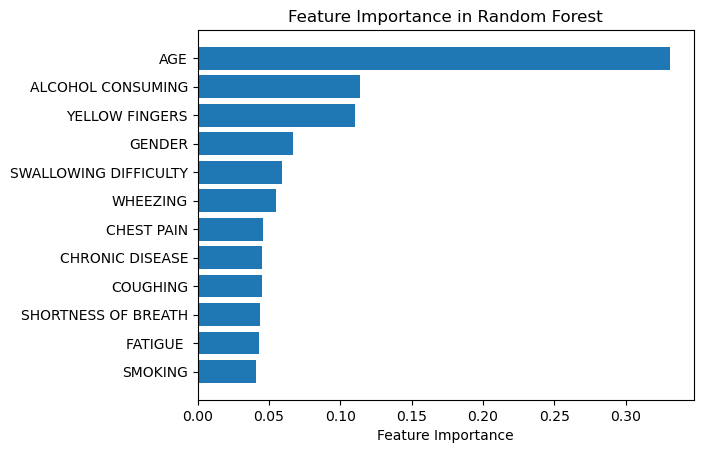

In [8]:
# Define ensemble methods with names in a list
classifiers = [
    ("Bagging", RandomForestClassifier(n_estimators=100, random_state=888)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=888, max_features="sqrt"))
]

# Initialsie dictionaries to store F1 scores and feature importances for each ensemble method
f1_scores = {}
feature_importances = {}

# Single loop to train, evaluate, and plot  for each ensemble method
for name, classifier in classifiers:
    # Train the model on training set
    classifier.fit(X_train, y_train)
    
    # Make predictions on validtaion set
    y_pred = classifier.predict(X_val)
    
    # Calculate F1 score
    f1 = f1_score(y_val, y_pred)
    f1_scores[name] = f1
    print(f"{name} F1 Score on Validation Set: {f1}") #evaluated against F-1 score
    
    # Get feature importances
    feature_importance = classifier.feature_importances_
    feature_importances[name] = feature_importance
    
    # Generate sorted horizontal bar plot for feature importance
    indices = np.argsort(feature_importance)
    plt.figure()
    plt.barh(np.array(X.columns)[indices], feature_importance[indices])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance in {name}')
    plt.show()

# K-Nearest Neighbour

In [9]:
# Create a pipeline to standardize the data and apply KNeighborsClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes the data
    ('knn', KNeighborsClassifier())  # KNN Classifier without setting neighbors yet
])

# Define the parameter grid for GridSearchCV
param_grid = {'knn__n_neighbors': list(range(1, 21))} # Search for the best k in the range 1 to 20

# Define the custom K-Fold cross-validation strategy of 5-fold
kf = KFold(n_splits=5, shuffle=True, random_state=888)  #CV with shuffling

# Initialize GridSearchCV with the custom KFold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='f1')

# Fit the GridSearchCV to find the best k
grid_search.fit(X_train, y_train)

# Get the best parameter for k
best_k = grid_search.best_params_['knn__n_neighbors']

# Retrieve best model using optimal k
best_knn_classifier =  grid_search.best_estimator_

# Use best model to predict on the validation set
y_pred_knn = best_knn_classifier.predict(X_val)

# Calculate metrics
f1 = f1_score(y_val, y_pred_knn)

# Display the results
print(f"F1 Score on validation set with k={best_k}: {f1}")

F1 Score on validation set with k=20: 0.913915857605178


# Neural Networks

In [31]:
# Set random seeds for reproducibility
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Custom F1 score metric function
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Round predictions to 0 or 1
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'), axis=0)
    
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)

# Define the neural network model
NN_model = Sequential([
    layers.Input(shape=(12,)),                 # Input layer with dynamic shape based on features in X
    layers.Dense(16, activation='softplus'),       # Hidden layer with 16 neurons and ReLU activation
    layers.Dense(8, activation='softplus'),        # Hidden layer with 8 neurons and ReLU activation
    layers.Dense(4, activation='softplus'),        # Hidden layer with 4 neurons and ReLU activation
    layers.Dense(1, activation='sigmoid')      # Output layer for binary classification
])

# Compile the model
sgd = SGD(learning_rate=0.01)
NN_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=[F1Score(threshold=0.5)])

# Train the model for 2000 epochs (each epoch uses the full training set, i.e. BGD)
history = NN_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Calculate F1 Scores for training and validation sets
y_val_pred_nn = (model.predict(X_val) > 0.5).astype(int)
display(y_val_pred_nn)
val_f1_nn = f1_score(y_val, y_val_pred_nn)
print(val_f1_nn)
print(confusion_matrix(y_val, y_val_pred_nn))


# Evaluate model on validation data
val_loss, val_f1 = NN_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

0.8884773662551441
[[   0  542]
 [   0 2159]]
Validation Loss: 0.3881, Validation F1 Score: 0.9145


In [30]:
# Set random seeds for reproducibility
random.seed(888)
tf.random.set_seed(888)
np.random.seed(888)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Define the neural network model
model = Sequential([
    layers.Input(shape=(X.shape[1],)),                 # Input layer with dynamic shape based on features in X
    layers.Dense(16, activation='softplus'),           # Hidden layer with 16 neurons and softplus activation
    layers.Dense(8, activation='softplus'),            # Hidden layer with 8 neurons and softplus activation
    layers.Dense(4, activation='softplus'),            # Hidden layer with 4 neurons and softplus activation
    layers.Dense(1, activation='sigmoid')              # Output layer for binary classification
])


# Compile the model
sgd = optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=sgd, 
              loss='binary_crossentropy',   # Loss function for binary classification
              metrics=[F1Score(threshold=0.5)])# Track f1 score performance metric during training


# Train the model for 2000 epochs (each epoch uses the full training set, i.e. BGD)
history = model.fit(X_train, y_train, epochs=2000, batch_size=len(X_train), verbose=0,
                   validation_data=(X_val, y_val))

# Calculate F1 Scores for training and validation sets
y_val_pred_nn = (model.predict(X_val) > 0.5).astype(int)
val_f1_nn = f1_score(y_val, y_val_pred_nn)


# Evaluate model on validation data
val_loss, val_f1 = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Loss: 0.4685, Validation F1 Score: 0.8885


In [32]:
print(val_f1_nn)

0.8884773662551441
